<a href="https://colab.research.google.com/github/19pa1a05b5/Neural-Networks/blob/main/micrograd_Basic_perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def f(x):
  return 3*x**2 - 4*x + 5

In [ ]:
f(3)

20

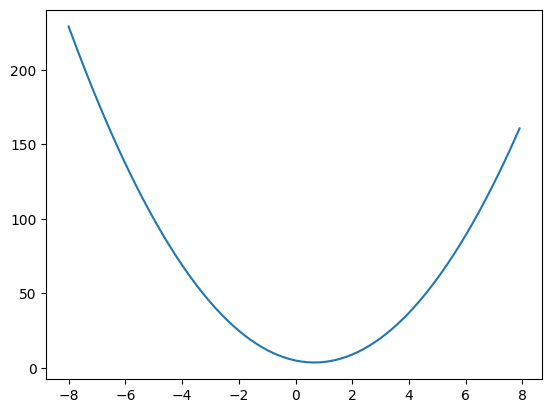

In [ ]:
xs = np.arange(-8,8,0.1)
ys = f(xs)
plt.plot(xs,ys)

In [ ]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

The Above calculations and graph told that how the differentitaion of a function can be done.

In [ ]:
#Lets create some complex equations
a=10
b=5
c=4
d=a*(b+c)
d

90

In [ ]:
h=0.00001

a=4
b=2
c=6

d1=c*(a+b)
c+=h
d2=c*(a+b)
#here we are trying to know the slope of the function or the differentiation of the function with respect to c. Similarly we can determine for all other varibales.
print("d1",d1)
print("d2",d2)
print("slope",(d2-d1)/h)

d1 36
d2 36.00006
slope 5.999999999772853


From here onwards lets build a basic neural network and learn how the forward pass and backpropogation done in a neural network.

In order to create a neural network lets create a class called value which is used as part of the neuron to do some calcultions and perform certain tasks.